# Task 1

Here we will see how our nn and autograd works.

Also we will review some Catalyst's abstractions, implement callbacks and datasets.

Unfortunately, python is slow, and implementing dynamic computational graph in pure python for product-ready solution is not a good idea. But this task will help you to understand what's happening when you call `backward` method for variable or tensor. Also it will help you in learning Catalyst framework and will teach how you to write your code in more Catalyst-like way.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from nn import Linear, ReLU, CrossEntropyLoss, Module
from optim import SGD
from engine import Value, Tensor
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Defining toy dataset

To be more human-readable and easy to understand, we want to store every data in key-value format.

So, the dataset should yield dict, moreover we will store train/valid datasets in a dict.

In [2]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, item):
        return {"features": self.X[item], "targets": self.y[item]}

    def __len__(self):
        return len(self.y)

X, y = make_moons(200, noise=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
datasets = {"train": Dataset(X_train, y_train), "valid": Dataset(X_val, y_val)}

Take a look on a data.

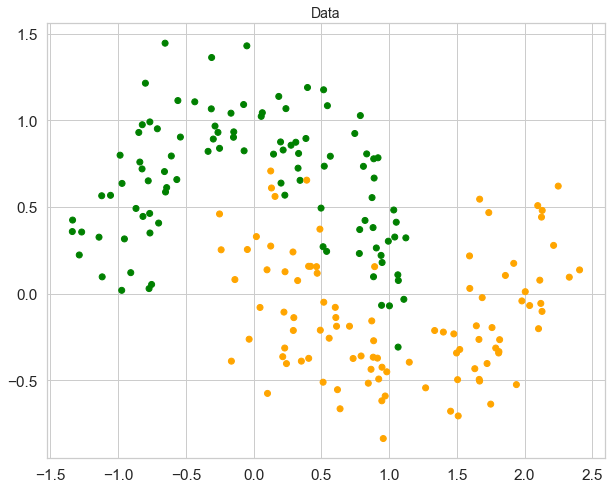

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Data", fontsize=14)
colors = list(map(lambda x: "green" if x ==0 else "orange", y))
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

### Model

Let's define our model in PyTorch-style. But don't forget to implement `parameters()` method.

In [4]:
class SimpleModel(Module):
    def __init__(self):
        # Create your own network
        self.layers = []
        self.layers.append(Linear(2, 16))
        self.layers.append(ReLU())
        self.layers.append(Linear(16, 2))

    def forward(self, inp):
        out = inp
        for layer in self.layers:
            out = layer(out)
        return out

    def parameters(self):
        out = []
        for layer in self.layers:
            out += layer.parameters()
        return out

## For loop

Let's start with simple train/test loop.

In [5]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)

num_epochs = 100
batch_size = 4
log_period = 5

for epoch in range(num_epochs):
    current_batch = []
    for k, dataset in datasets.items():
        loader_metrics = {}
        epoch_loss = 0
        epoch_accuracy = 0
        for idx, data in enumerate(dataset):
            last = idx == (len(dataset)-1)
            current_batch.append(data)
            if last or len(current_batch) == batch_size:
                features, labels = [], []
                for row in current_batch:
                    features.append([Value(value) for value in row["features"]])
                    labels.append(Value(row["targets"]))
                features = Tensor(features)
                labels = Tensor(labels)
                
                res = model(features)
                loss = criterion(res, labels)
                predict = res.argmax(dim = 1)
                accuracy = np.mean([labels[i].data == predict[i] for i in range(len(current_batch))])

                if k == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                batch_metrics = {"loss": loss.data, "accuracy": accuracy}

                for metric, value in batch_metrics.items():
                    if metric not in loader_metrics:
                        loader_metrics[metric] = []
                    loader_metrics[metric].append(value)    
                current_batch = []
                
        if epoch == 0 or (epoch + 1) %  log_period == 0:
            log_string = []
            for metric, value in loader_metrics.items():
                value = np.mean(loader_metrics[metric])
                log_string.append(f"{metric}: {value:.2f}")
            log_string = " ".join(log_string)
            print(f"Epoch {epoch + 1:3}/{num_epochs:3}: {k} {log_string}")

Epoch   1/100: train loss: 0.47 accuracy: 0.81
Epoch   1/100: valid loss: 0.43 accuracy: 0.75
Epoch   5/100: train loss: 0.32 accuracy: 0.88
Epoch   5/100: valid loss: 0.34 accuracy: 0.80
Epoch  10/100: train loss: 0.30 accuracy: 0.89
Epoch  10/100: valid loss: 0.31 accuracy: 0.83
Epoch  15/100: train loss: 0.28 accuracy: 0.90
Epoch  15/100: valid loss: 0.29 accuracy: 0.88
Epoch  20/100: train loss: 0.25 accuracy: 0.91
Epoch  20/100: valid loss: 0.25 accuracy: 0.92
Epoch  25/100: train loss: 0.22 accuracy: 0.92
Epoch  25/100: valid loss: 0.23 accuracy: 0.93
Epoch  30/100: train loss: 0.19 accuracy: 0.91
Epoch  30/100: valid loss: 0.20 accuracy: 0.93
Epoch  35/100: train loss: 0.17 accuracy: 0.93
Epoch  35/100: valid loss: 0.18 accuracy: 0.95
Epoch  40/100: train loss: 0.15 accuracy: 0.94
Epoch  40/100: valid loss: 0.17 accuracy: 0.97
Epoch  45/100: train loss: 0.14 accuracy: 0.95
Epoch  45/100: valid loss: 0.16 accuracy: 0.97
Epoch  50/100: train loss: 0.13 accuracy: 0.95
Epoch  50/100


## General training loop - Catalyst intro - Runner¶

Code above can be reused for almost all machine learning task. Let's take a look on experiment structure

```
for stage in stage:
    for epoch in epochs:
        for loader on loaders:
            for batch in loader:
                # do something
```

### Runner

In most cases we only need to adapt our batch handling method. And here comes the Runner.

Runner is the main part of your experiment. It runs train loop, calls callbacks (we will discusds them later) and keeps track on your model. And the only thing you need to change is _handle_batch method.


In [6]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets
        self.batch_size = batch_size

        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch, train=True):
        """
        Stores the main logic of data aggregating.
        """
        features, labels = [], []
        for row in batch:
            features.append([Value(value) for value in row["features"]])
            labels.append(Value(row["targets"]))
        features, labels = Tensor(features), Tensor(labels)

        res = self.model(features)
        loss = criterion(res, labels)
        predict = res.argmax(dim = 1)
        accuracy = np.mean([labels[i].data == predict[i] for i in range(len(batch))])

        if train:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.batch_metrics = {"loss": loss.data, "accuracy": accuracy}


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []
                train = dataset_name == "train"

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        # Handle batch
                        self._handle_batch(current_batch, train=train)
                        current_batch = []

                        for k, v in self.batch_metrics.items():
                            if k not in self.loader_metrics:
                                self.loader_metrics[k] = []
                            self.loader_metrics[k].append(v)
                
                for metric, value in self.loader_metrics.items():
                    value = np.mean(self.loader_metrics[metric])
                    self.loader_metrics[metric] = value
                    print(f"epoch {epoch}: {dataset_name} {metric} - {value}")

### Run training

In [7]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
)
runner.train(10)

epoch 0: train loss - 0.5587963707589888
epoch 0: train accuracy - 0.6808510638297872
epoch 0: valid loss - 0.472525077547702
epoch 0: valid accuracy - 0.7333333333333332
epoch 1: train loss - 0.3834280774675105
epoch 1: train accuracy - 0.8297872340425532
epoch 1: valid loss - 0.395531203801134
epoch 1: valid accuracy - 0.7833333333333333
epoch 2: train loss - 0.3435885169908996
epoch 2: train accuracy - 0.8652482269503545
epoch 2: valid loss - 0.3661345281050314
epoch 2: valid accuracy - 0.7999999999999999
epoch 3: train loss - 0.3316712463628668
epoch 3: train accuracy - 0.8794326241134752
epoch 3: valid loss - 0.35228073745416444
epoch 3: valid accuracy - 0.7999999999999999
epoch 4: train loss - 0.3260894467096119
epoch 4: train accuracy - 0.8652482269503545
epoch 4: valid loss - 0.3450663908879057
epoch 4: valid accuracy - 0.8166666666666667
epoch 5: train loss - 0.3227468434337636
epoch 5: train accuracy - 0.8652482269503545
epoch 5: valid loss - 0.340697822170717
epoch 5: valid 

### Visualization

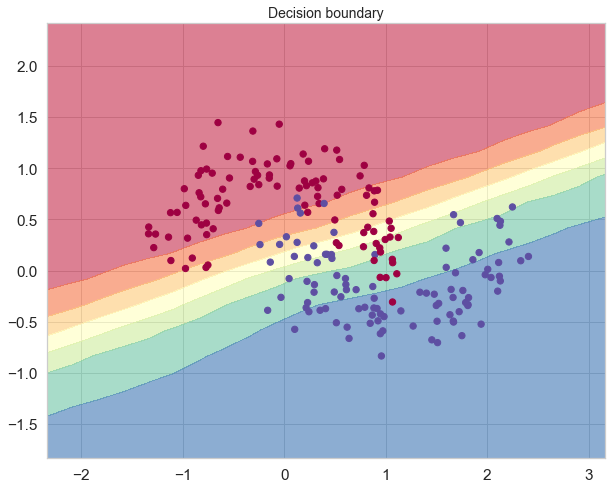

In [8]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor([list(map(Value, xrow)) for xrow in Xmesh])
scores = model(inputs)
Z = np.array([s[1].exp().data/(s[0].exp()+s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## General training loop - Catalyst intro - Callbacks

But could we make it even more general? Should we rewrite loss.backward or compute accuracy again and again? Do we really need it?

I don't think so, I think, we could introduce another general abstaction for typical train-loop logic. Let's introduce Callbacks!

### Callbacks

In catalyst callbacks have significant impact in everything you do.
Let's try to implement some of them.

There are a list of moments, where callbacks can be integrated. We will need only three of them.
```
on_stage_start
    on_epoch_start
        on_loader_start
            on_batch_start
------->    on_batch_end
----->  on_loader_end
--> on_epoch_end
on_stage_end
```

In [9]:
class Callback:
    def on_stage_start(self):
        pass

    def on_stage_end(self):
        pass

    def on_epoch_start(self):
        pass

    def on_epoch_end(self, runner):
        pass

    def on_loader_start(self):
        pass

    def on_loader_end(self, runner):
        pass

    def on_batch_start(self, runner):
        pass

    def on_batch_end(self, runner):
        pass


class LossCallback(Callback):
    """
    Aggregating loss value.
    """
    def __init__(self):
        self.cum_loss = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action.

        Accumulates loss and num batches.

        Args:
            output: dict with loss and other model's outputs.
        """
        self.cum_loss += runner.output["loss"]
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            loss over the loader.
        """
        runner.epoch_metrics["loss"] = self.cum_loss / self.num_batches
        self.cum_loss = 0
        self.num_batches = 0


class AccuracyCallback(Callback):
    """
    Aggregating accuracy value.
    """
    def __init__(self):
        self.cum_accuracy = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action

        Accumulates number of correct predictions.

        Args:
            output: dict with number of the correct predictions
        """
        self.cum_accuracy += runner.output["accuracy"]
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            accuracy value over the loader.
        """
        runner.epoch_metrics["accuracy"] = self.cum_accuracy / self.num_batches
        self.cum_accuracy = 0
        self.num_batches = 0


class LoggerCallback(Callback):
    """
    Log metrics to output.
    """
    def __init__(self, log_period):
        self.log_period = log_period

    # Implement `on_loader_end` instead of `on_epoch_end` because
    # in `epoch_metrics` we don't differentiate information
    # related to different loaders
    # (maybe we should, but two approaches above were written differently)
    def on_loader_end(self, runner):
        """
        On loader end action.

        Prints all epoch metrics if log_period is suitable.

        Args:
            epoch_metrics: dict with epoch metrics
            epoch: current epoch
        """
        if runner.epoch == 0 or (runner.epoch + 1) % self.log_period == 0:
            log_string = []
            for metric, value in runner.epoch_metrics.items():
                log_string.append(f"{metric}: {value:.4f}")
            log_string = " ".join(log_string)
            print(f"Epoch: {runner.epoch + 1:3}: {runner.dataset_name} {log_string}")


class OptimizerCallback(Callback):
    def on_batch_start(self, runner):
        if runner.dataset_name == "train":
            runner.optimizer.zero_grad()

    def on_batch_end(self, runner):
        features, labels = [], []
        for row in runner.input:
            features.append([Value(value) for value in row["features"]])
            labels.append(Value(row["targets"]))
        features, labels = Tensor(features), Tensor(labels)

        logits = runner.model(features)
        loss = criterion(logits, labels)

        if runner.dataset_name == "train":
            loss.backward()
            runner.optimizer.step()

In [10]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size,
        callbacks,
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size
        self.callbacks = callbacks
        
        self.input = []
        self.output = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch):
        """
        Stores the main logic of data aggregating.
        """
        features, labels = [], []
        for row in batch:
            features.append([Value(value) for value in row["features"]])
            labels.append(Value(row["targets"]))
        features, labels = Tensor(features), Tensor(labels)
        
        res = self.model(features)
        loss = criterion(res, labels)
        predict = res.argmax(dim = 1)
        accuracy = np.mean([labels[i].data == predict[i] for i in range(len(batch))])

        self.input = batch
        self.output = {"loss": loss.data, "accuracy": accuracy}

    def train(self, num_epochs=100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        for clb in self.callbacks.values():
                            clb.on_batch_start(self)

                        self._handle_batch(current_batch)

                        current_batch = []

                        for clb in self.callbacks.values():
                            clb.on_batch_end(self)

                for clb in self.callbacks.values():
                    clb.on_loader_end(self)

### Run training

In [11]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=3,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=5),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(50)

Epoch:   1: train loss: 0.6244 accuracy: 0.6312
Epoch:   1: valid loss: 0.5128 accuracy: 0.7167
Epoch:   5: train loss: 0.3239 accuracy: 0.8582
Epoch:   5: valid loss: 0.3369 accuracy: 0.8167
Epoch:  10: train loss: 0.3141 accuracy: 0.8511
Epoch:  10: valid loss: 0.3225 accuracy: 0.8333
Epoch:  15: train loss: 0.3068 accuracy: 0.8582
Epoch:  15: valid loss: 0.3141 accuracy: 0.8500
Epoch:  20: train loss: 0.2914 accuracy: 0.8582
Epoch:  20: valid loss: 0.3002 accuracy: 0.8500
Epoch:  25: train loss: 0.2656 accuracy: 0.8723
Epoch:  25: valid loss: 0.2753 accuracy: 0.8500
Epoch:  30: train loss: 0.2347 accuracy: 0.9149
Epoch:  30: valid loss: 0.2448 accuracy: 0.9167
Epoch:  35: train loss: 0.1984 accuracy: 0.9220
Epoch:  35: valid loss: 0.2042 accuracy: 0.9500
Epoch:  40: train loss: 0.1695 accuracy: 0.9433
Epoch:  40: valid loss: 0.1738 accuracy: 0.9500
Epoch:  45: train loss: 0.1427 accuracy: 0.9433
Epoch:  45: valid loss: 0.1582 accuracy: 0.9500
Epoch:  50: train loss: 0.1285 accuracy:

### Visualization

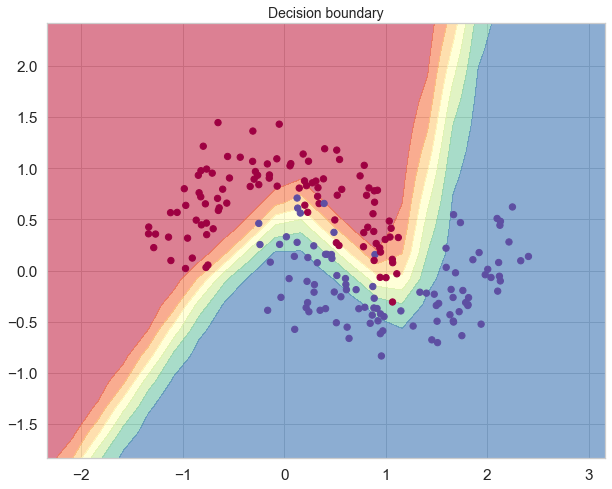

In [12]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor([list(map(Value, xrow)) for xrow in Xmesh])
scores = model(inputs)
Z = np.array([s[1].exp().data / (s[0].exp() + s[1].exp()).data for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 8))
plt.title("Decision boundary", fontsize=14)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


## MNIST

Try to train model on MNIST task!

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
class MNISTDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return {"features": ..., "targets": ...}

    def __len__(self):
        return len(self.y)

# Python is slow, that's why we use only small group of object
datasets = {
    "train": MNISTDataset(X_train[:2000], y_train[:2000]),
    "valid": MNISTDataset(X_val[:200], y_val[:200])
} 

In [ ]:
class MnistModel(Module):
    def __init__(
        self,
        inp_shape=28*28,
        out_shape=10,
        hidden_shapes=[10, 10]
    ):
        # Create your model!

    def forward(self, inp):
        return ...

    def parameters(self):
        parameters = [] # Don't forget about parameters!
        return parameters

In [ ]:
criterion = CrossEntropyLoss()
model = MnistModel()
optimizer = SGD(model.parameters(), lr=0.1)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=16,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=1),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(5, verbose=True)